# Train SVM Classifier Model

**TLDR:** ***If you want to try to run this training model file without setting up anything, we provide a link to the kaggle version of this notebook that you can run on cloud: [Train SVM Classifier Model](https://www.kaggle.com/code/trunganhchu/svm-classifier)***


After we got extracted face features from `Pipeline1 DataPreprocessing.ipynb` (in form of vector), we have many way to deal with face verifaction problem. Some serveral methods are:

- Compute directly the distance between two face vectors (from a input image when login and the registered images). This way is simple without any training step, but it is not robust and not general.

- Train a classifier model to classify if two vectors are considered as similiar or not (meaning the input image is the same person with the registered image). This way is more robust and general, but it requires a training step. We seen it as a binary classification problem. Given input as a pair of face vectors, the model will output 1 if the two vectors are considered as similar, and 0 otherwise. Some common models for this problem are SVM, K Nearest Neighbors, Naive Bayes, or even more robust deep learning models.

In this task, we try **SVM (Support Vector Machine)** model to solve the problem.

In reality scenario, SVM often used for this kind of task since it is particularly effective in high-dimensional spaces, which is typical for face feature data.

# 1.Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report


# 2. Create Training and Testing Data

Here's the pipeline for preparing the data for training a classifier in the face verification process:

1. **Load Embeddings**:

- Iterate through the subfolders in the `face_embeddings`directory
- Load the facial embeddings from the `embeddings.npz` files in each subfolder


2. **Create Positive Pairs**:

- For each person's embeddings, create pairs of embeddings by combining all possible pairs inside that person's embeddings


3. **Create Negative Pairs with Random Sampling**:

- Randomly select a limited number of embeddings from other subfolders to create negative pairs. We limit the number of samples to pair in each subfolder and also the number of subfolders to sample from. This limit the number of negative pairs to take, since try all combined pairs will be approximately n * (n-1) / 2 with n is the number of embeddings in the dataset, overwhelming our compution resource.


4. **Generate Labels**:

- Assign label 1 to positive pairs (same person)
- Assign label 0 to negative pairs (different persons)


5. **Prepare Training Data**:

- Combine the pairs and their corresponding labels into arrays 
- Shuffle the data
- Devide the data into training and testing sets


This prepared data can now be used to train a classifier model, such as an SVM, for face verification

![GenerateTrainingData.drawio.png](assets/images/GenerateTrainingData.drawio.png)

## Load Embeddings, create Positive and Negative Pairs, Create Labels

In [2]:
# Load embeddings from the .npz files
# Parameters:
# embedding_dir: directory containing the embeddings
def load_embeddings(embedding_dir):
    embeddings_dict = {}
    for subfolder in os.listdir(embedding_dir): # Process each subfolder/person
        subfolder_path = os.path.join(embedding_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data = np.load(os.path.join(subfolder_path, 'embeddings.npz'))
            embeddings = data['arr_0']
            embeddings_dict[subfolder] = embeddings
    return embeddings_dict # Dictionary with key: person name, value: embeddings


# Create pairs of embeddings and corresponding labels
# Parameters: 
# embeddings_dict: dictionary containing embeddings of each person
# num_negative_samples: number of negative samples to create for each positive pair
# num_subfolders_to_sample: number of subfolders to sample for negative pairs
def create_pairs(embeddings_dict, num_negative_samples=5, num_subfolders_to_sample=3):
    pairs = []
    labels = []
    persons = list(embeddings_dict.keys())
    
    # Create positive pairs
    for person in persons:
        embeddings = embeddings_dict[person]
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                pairs.append([embeddings[i], embeddings[j]])
                labels.append(1)
    
    # Create negative pairs with random sampling
    for person in persons:
        embeddings = embeddings_dict[person]
        other_persons = [p for p in persons if p != person]
        sampled_persons = random.sample(other_persons, min(num_subfolders_to_sample, len(other_persons)))
        
        for emb in embeddings:
            for sampled_person in sampled_persons:
                sampled_embeddings = embeddings_dict[sampled_person]
                sampled_negative_embeddings = random.sample(list(sampled_embeddings), min(num_negative_samples, len(sampled_embeddings)))
                
                for neg_emb in sampled_negative_embeddings:
                    pairs.append([emb, neg_emb])
                    labels.append(0)
    
    return np.array(pairs), np.array(labels)


# Load embeddings
embedding_dir = './preprocessed_data/face_embeddings'
embeddings_dict = load_embeddings(embedding_dir)

# Create pairs and labels with random sampling for negative pairs
pairs, labels = create_pairs(embeddings_dict, num_negative_samples=1, num_subfolders_to_sample=1)
print("Number of pairs:", len(pairs))
print("Number of positive pairs:", sum(labels)) #since positive pairs are labeled as 1, negative are 0, 0 + 1 = 1
print("Number of negative pairs:", len(labels) - sum(labels))

# Prepare data
X = np.array([np.concatenate(pair) for pair in pairs])
y = labels

print("Shape of training data:", X.shape)
print("Shape of labels:", y.shape)

Number of pairs: 19626
Number of positive pairs: 17637
Number of negative pairs: 1989
Shape of training data: (19626, 2, 512)
Shape of labels: (19626,)


Output: Shape of training data: (156, 2, 512) indicate that we have 156 pairs, each pair has 2 embeddings vector with 512 dimensions.

Also, notice that the number of positive pairs and negative pairs should be balanced, so we can have a good training data.

## Split Data into Training and Testing Sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# print sixe of training and testing data

print("Size of training data:", X_train.shape)
print("Size of testing data:", X_test.shape)


Size of training data: (15700, 2, 512)
Size of testing data: (3926, 2, 512)


# 3. Train SVM Model

In [5]:

# First, we need to flatten the training data
print("Shape of training data:", X_train.shape)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
print("Shape of flattened training data:", X_train_flatten.shape)


# Second, we need to scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flatten)



Shape of training data: (15700, 2, 512)
Shape of flattened training data: (15700, 1024)


In [ ]:
# now, we can train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

In [ ]:
# Save the model

# First, create a seprate directory to save the all the models weights file
model_dir = './model_saved'
os.makedirs(model_dir, exist_ok=True)

with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

with open(os.path.join(model_dir, 'svm_model.pkl'), 'wb') as f:
    pickle.dump(svm_model, f)

# 4. Load model from disk


In [ ]:
# Load model from the saved file

# Load the scaler and the SVM model
with open('./model_saved/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('./model_saved/svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# 6. Evaluate Model

Training Accuracy: 0.9561170212765957
Testing Accuracy: 0.873015873015873


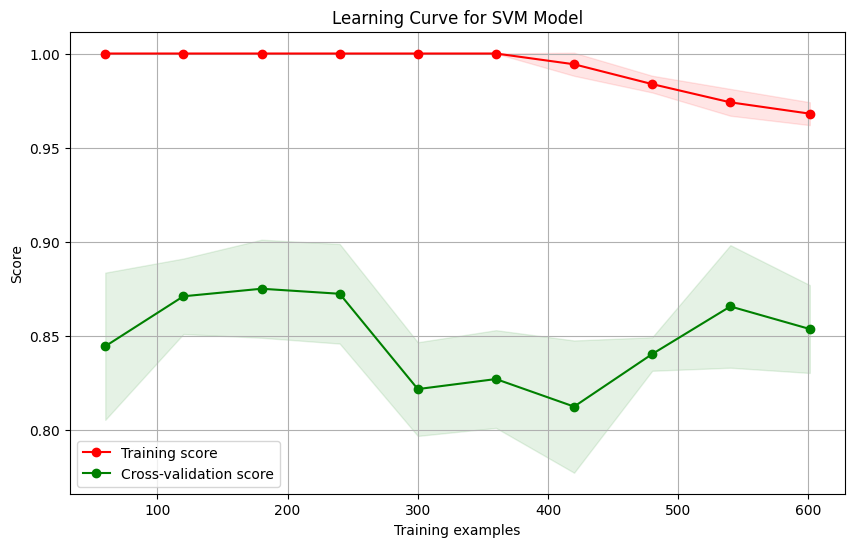

In [ ]:
# Evaluate the model
train_accuracy = svm_model.score(X_train_scaled, y_train)

# Flatten the testing data
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
X_test_scaler = scaler.transform(X_test_flatten)


test_accuracy = svm_model.score(X_test_scaler, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
# Plot learning curve to check for overfitting

train_sizes, train_scores, test_scores = learning_curve(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve for SVM Model')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()



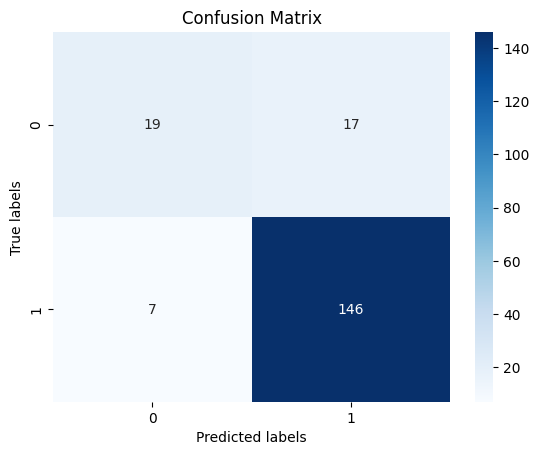

              precision    recall  f1-score   support

           0       0.73      0.53      0.61        36
           1       0.90      0.95      0.92       153

    accuracy                           0.87       189
   macro avg       0.81      0.74      0.77       189
weighted avg       0.86      0.87      0.86       189



In [ ]:
# Plot the confusion matrix
y_pred = svm_model.predict(X_test_scaler)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred))
